<a href="https://colab.research.google.com/github/suneelmatham/rl-trading/blob/master/X2_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
! git clone https://github.com/wai-i/Pair-Trading-Reinforcement-Learning.git

Cloning into 'Pair-Trading-Reinforcement-Learning'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 136 (delta 1), reused 0 (delta 0), pack-reused 129
Receiving objects: 100% (136/136), 10.13 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [0]:
% cd /content/Pair-Trading-Reinforcement-Learning
! ls

/content/Pair-Trading-Reinforcement-Learning
CONFIG	EXAMPLE  MAIN	    README.md	      STATICS	Structure.PNG  venv
DATA	LICENSE  PROCESSOR  requirements.txt  STRATEGY	UTIL


In [0]:
%pycat CONFIG/config_train.yml

In [0]:
! rm CONFIG/config_train.yml

In [0]:
%%writefile CONFIG/config_train.yml
StateSpaceNetworkSampleType: index
StateSpaceEngineSampleConversion: index_to_dict


ActionSpaceNetworkSampleType: exploration
ActionSpaceEngineSampleConversion: index_to_dict


AgentLearningRate: 0.001
AgentEpochCounter: Counter_1
AgentIterationCounter: Counter_2
AgentIsUpdateNetwork: True


ExplorationMethod: boltzmann
ExplorationBoltzmannProbAttribute: prob_dist
ExplorationCounter: Counter_4


AgentModelSaverSavePath: ./STATICS/CKPT
AgentModelSaverSaveName: cointegration


AgentModelSaverRestorePath: ./STATICS/CKPT
AgentModelSaverRestoreName: cointegration


ExperienceReplay: True
ExperienceBufferBufferSize: 10000
ExperienceBufferSamplingSize: 1
ExperienceReplayFreq: 5


RecorderDataField: [NETWORK_ACTION, ENGINE_REWARD, ENGINE_RECORD]
RecorderRecordFreq: 1


Counter:
  Counter_1:
    name: Epoch
    start_num: 0
    # end_num: 10
    end_num: 5
    step_size: 1
    n_buffer: 0
    is_descend: False
    print_freq: 1
  Counter_2:
    name: Iteration
    start_num: 0
    end_num: 10000
    step_size: 1
    n_buffer: 10000
    is_descend: False
    print_freq: 1000
  Counter_3:
    name: EGreedyProb
    start_num: 1
    end_num: 0.1
    step_size: 0.0001
    n_buffer: 30000
    is_descend: True
    print_freq:
  Counter_4:
    name: BoltzmannTemp
    start_num: 1
    end_num: 0.2
    step_size: 0.0001
    n_buffer: 30000
    is_descend: True
    print_freq:

Writing CONFIG/config_train.yml


In [0]:
import pandas as pd
import numpy as np
import MAIN.Basics as basics
import MAIN.Reinforcement as RL
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from UTIL import FileIO
from STRATEGY.Cointegration import EGCointegration

In [0]:
config_path  = 'CONFIG/config_train.yml'
config_train = FileIO.read_yaml(config_path)

In [0]:
# x = pd.read_csv('STATICS/PRICE/JNJ.csv')
# y = pd.read_csv('STATICS/PRICE/PG.csv')
x = pd.read_csv('/content/gdrive/My Drive/Datasets/ACC.csv')
y = pd.read_csv('/content/gdrive/My Drive/Datasets/AMBUJACEM.csv')
x, y = EGCointegration.clean_data(x, y, 'date', 'close')

In [0]:
print(len(x), len(y))

438582 438582


In [0]:
# Separate training and testing sets
train_pct = 0.7
train_len = round(len(x) * 0.7)
idx_train = list(range(0, train_len))
idx_test  = list(range(train_len, len(x)))
EG_Train = EGCointegration(x.iloc[idx_train, :], y.iloc[idx_train, :], 'date', 'close')
EG_Test  = EGCointegration(x.iloc[idx_test,  :], y.iloc[idx_test,  :], 'date', 'close')

In [0]:
# Create action space
n_hist    = list(np.arange(60, 601, 60))
n_forward = list(np.arange(120, 1201, 120))
trade_th  = list(np.arange(1,  5.1, 1))
stop_loss = list(np.arange(1,  2.1, 0.5))
cl        = list(np.arange(0.05,  0.11, 0.05))
actions   = {'n_hist':    n_hist,
             'n_forward': n_forward,
             'trade_th':  trade_th,
             'stop_loss': stop_loss,
             'cl':        cl}
n_action  = int(np.product([len(actions[key]) for key in actions.keys()]))

In [0]:
# Create state space
transaction_cost = [0.001]
states  = {'transaction_cost': transaction_cost}
n_state = len(states)

In [0]:
# Assign state and action spaces to config
config_train['StateSpaceState'] = states
config_train['ActionSpaceAction'] = actions

In [0]:
# Create and build network
one_hot  = {'one_hot': {'func_name':  'one_hot',
                        'input_arg':  'indices',
                         'layer_para': {'indices': None,
                                        'depth': n_state}}}
output_layer = {'final': {'func_name':  'fully_connected',
                          'input_arg':  'inputs',
                          'layer_para': {'inputs': None,
                                         'num_outputs': n_action,
                                         'biases_initializer': None,
                                         'activation_fn': tf.nn.relu,
                                         'weights_initializer': tf.ones_initializer()}}}

state_in = tf.placeholder(shape=[1], dtype=tf.int32)

N = basics.Network(state_in)
N.build_layers(one_hot)
N.add_layer_duplicates(output_layer, 1)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
# Create learning object and perform training
RL_Train = RL.ContextualBandit(N, config_train, EG_Train)

In [0]:
sess = tf.Session()
RL_Train.process(sess, save=False, restore=False)


Counter [Iteration]: 1000 steps processed...
Counter [Iteration]: 2000 steps processed...
Counter [Iteration]: 3000 steps processed...
Counter [Iteration]: 4000 steps processed...
Counter [Iteration]: 5000 steps processed...
Counter [Iteration]: 6000 steps processed...
Counter [Iteration]: 7000 steps processed...
Counter [Iteration]: 8000 steps processed...
Counter [Iteration]: 9000 steps processed...
Counter [Iteration]: 10000 steps processed...
Counter [Iteration]: 11000 steps processed...
Counter [Iteration]: 12000 steps processed...
Counter [Iteration]: 13000 steps processed...
Counter [Iteration]: 14000 steps processed...
Counter [Iteration]: 15000 steps processed...
Counter [Iteration]: 16000 steps processed...
Counter [Iteration]: 17000 steps processed...
Counter [Iteration]: 18000 steps processed...
Counter [Iteration]: 19000 steps processed...
Counter [Iteration]: 20000 steps processed...
Counter [Iteration]: Process completed.
Counter [Epoch]: 1 steps processed...
Counter [I

In [0]:
# Extract training results
action = RL_Train.recorder.record['NETWORK_ACTION']
reward = RL_Train.recorder.record['ENGINE_REWARD']
print(np.mean(reward))

-0.01577132988266612


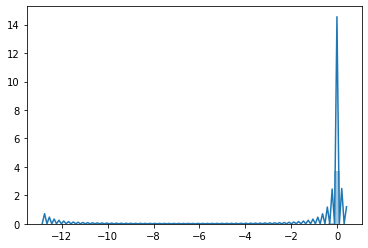

In [0]:
df1 = pd.DataFrame()
df1['action'] = action
df1['reward'] = reward
mean_reward = df1.groupby('action').mean()
sns.distplot(mean_reward)

In [0]:
# Test by trading continuously
[opt_action] = sess.run([RL_Train.output], feed_dict=RL_Train.feed_dict)
opt_action = np.argmax(opt_action)
action_dict = RL_Train.action_space.convert(opt_action, 'index_to_dict')
indices = range(601, len(EG_Test.x) - 1200)

In [0]:
pnl = pd.DataFrame()
pnl['Time'] = EG_Test.timestamp
pnl['Trade_Profit'] = 0
pnl['Cost'] = 0
pnl['N_Trade'] = 0

In [0]:
%%time
import warnings
warnings.filterwarnings('ignore')
for i in indices:
    # if i % 100 == 0:
    #     # print(i)
    EG_Test.process(index=i, transaction_cost=0.001, **action_dict)
    trade_record = EG_Test.record
    if (trade_record is not None) and (len(trade_record) > 0):
        # print('value at {}'.format(i))
        trade_record = pd.DataFrame(trade_record)
        trade_cost   = trade_record.groupby('trade_time')['trade_cost'].sum()
        close_cost   = trade_record.groupby('close_time')['close_cost'].sum()
        profit       = trade_record.groupby('close_time')['profit'].sum()
        open_pos     = trade_record.groupby('trade_time')['long_short'].sum()
        close_pos    = trade_record.groupby('close_time')['long_short'].sum() * -1

        pnl['Cost'].loc[pnl['Time'].isin(trade_cost.index)] += trade_cost.values
        pnl['Cost'].loc[pnl['Time'].isin(close_cost.index)] += close_cost.values
        pnl['Trade_Profit'].loc[pnl['Time'].isin(close_cost.index)] += profit.values
        pnl['N_Trade'].loc[pnl['Time'].isin(trade_cost.index)] += open_pos.values
        pnl['N_Trade'].loc[pnl['Time'].isin(close_cost.index)] += close_pos.values

warnings.filterwarnings(action='once')

KeyboardInterrupt: ignored

In [0]:
# Plot the testing result
pnl['PnL'] = (pnl['Trade_Profit'] - pnl['Cost']).cumsum()
plt.plot(pnl['PnL'])
plt.plot(pnl['N_Trade'])
plt.plot(pnl['Time'], pnl['PnL'])

Error in callback <function flush_figures at 0x7f040b56d7b8> (for post_execute):


KeyboardInterrupt: ignored

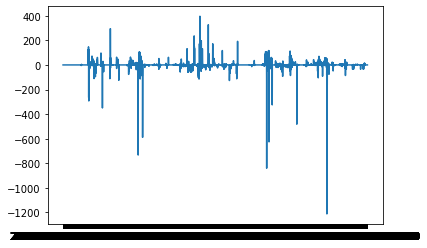

In [0]:
plt.plot(pnl['Time'], pnl['N_Trade'])

In [0]:
len(pnl)

16800

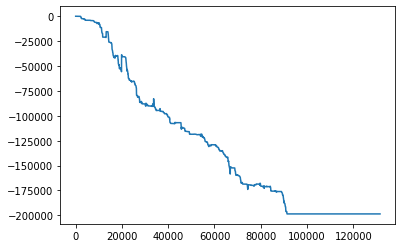

In [0]:
plt.plot(pnl['PnL'])

In [0]:
sess.close()